### Introduction

This project uses TensorFlow to build a neural network that uses embedding, and a convolution layer to do the sentiment analysis.

### Imports

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import nltk
import bz2
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

print(tf.__version__)

2.3.0


### Load the training set

Since we don't have a validation set, we will split the training by 80:20 and use the 20% for validation. The seed is critical to make sure the same rows don't go into the validation set and training set when we make the same call again for validation set

In [2]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'data/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 2860421 files belonging to 2 classes.
Using 2288337 files for training.


### Load the validation set

In [3]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'data/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 2860421 files belonging to 2 classes.
Using 572084 files for validation.


### Load the test set

In [4]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'data/test', 
    batch_size=batch_size)

Found 400000 files belonging to 2 classes.


### Define functions to preprocess the text

Load the stop words, lemmatizer and english corpus

In [5]:
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

nltk.download('wordnet')
lemmatizer = nltk.stem.WordNetLemmatizer()

# Downloads all english dictionary words
nltk.download('words')
english_words = set(nltk.corpus.words.words())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\siva.alagarsamy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\siva.alagarsamy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\siva.alagarsamy\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [6]:
punctuations = "!@#$%^&*()_-+={[}]|\:;'<,>.?/~`"

def preprocess_text(text):
    words = []
    tokens = re.findall('\w+', str(text))
    for w in tokens:
        # Convert to lower
        w = w.lower()
        
        # Remove punctuations
        w = "".join([char for char in w if char not in punctuations])
        
        # Don't add word if it is a stopword
        if w not in stop_words:      
            
            # Make sure it is valid english word
            if w in english_words:
                # Lemmatize word
                w = lemmatizer.lemmatize(w, 'v')  #Assume most of the review is verb part of the speech (POS)
                words.append(w)
    return " ".join(words)       

In [7]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')


### Create the vectorization layer

In [8]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

### Adapt the vectorization layer to the train dataset

In [9]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)
len(vectorize_layer.get_vocabulary())

10000

### Define a vectorization function

In [10]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

### Create a train, validation and test dataset with the vectorization function

In [11]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Optimize the dataset

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Define the model

The first layer is an Embedding layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).

Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
The last layer is densely connected with a single output node.

We also add a Dropout layer to avoid overfitting

In [13]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


### Compile the model

In [14]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the mode

In [15]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
71511/71511 [==============================] - 5003s 70ms/step - loss: 0.2769 - binary_accuracy: 0.8929 - val_loss: 0.2497 - val_binary_accuracy: 0.9044
Epoch 2/10
71511/71511 [==============================] - 643s 9ms/step - loss: 0.2511 - binary_accuracy: 0.9039 - val_loss: 0.2488 - val_binary_accuracy: 0.9051
Epoch 3/10
71511/71511 [==============================] - 616s 9ms/step - loss: 0.2504 - binary_accuracy: 0.9044 - val_loss: 0.2481 - val_binary_accuracy: 0.9055
Epoch 4/10
71511/71511 [==============================] - 600s 8ms/step - loss: 0.2498 - binary_accuracy: 0.9047 - val_loss: 0.2480 - val_binary_accuracy: 0.9056
Epoch 5/10
71511/71511 [==============================] - 579s 8ms/step - loss: 0.2493 - binary_accuracy: 0.9049 - val_loss: 0.2477 - val_binary_accuracy: 0.9058
Epoch 6/10
71511/71511 [==============================] - 578s 8ms/step - loss: 0.2490 - binary_accuracy: 0.9052 - val_loss: 0.2471 - val_binary_accuracy: 0.9060
Epoch 7/10
71511/71511 [==

### Evaluate the model with the test dataset

In [16]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

12500/12500 [==============================] - 670s 54ms/step - loss: 0.2468 - binary_accuracy: 0.90601s - loss: 0.2468 - binary_ac
Loss:  0.24679097533226013
Accuracy:  0.9059774875640869


### Plot the loss over the training interatio

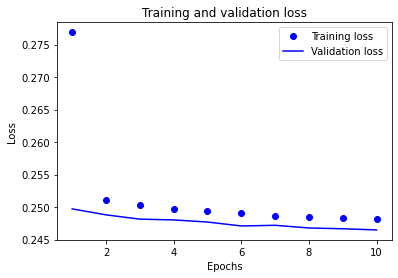

In [17]:
history_dict = history.history
history_dict.keys()

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

###  Plot the accuracy over the training iterations

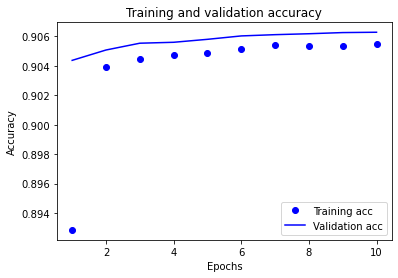

In [18]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Export the model to a file

In [ ]:
The model has to be wrapped with the vectorizer layer and an input layer. We added a sigmoid activation layer

In [41]:
export_model = tf.keras.Sequential([
  tf.keras.Input(shape=(1,), dtype="string"),
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)
export_model.save('export_model')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `